# Custom Decoder Demo Notebook

Welcome to the custom decoder demo notebook! In this notebook, we will showcase the capabilities of SAM's image encoder with custom decoder.

## SAM's Image Encoder

**Image Encoder** in SAM captures essential features from the input image, extracting high-level representations that encode relevant information about objects and their context. This step allows SAM to understand the visual content of the image. Here, we want to use these features and train a custom decoder on the top of that to generate mask.

Let's start by importing the necessary libraries:

In [1]:
import sys

sys.path.append("../")

In [2]:
from segmate.segmenter import SAM
from segmate import utils
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### Initializing SegMate

To start using SegMate, we need to create an instance of the SegMate class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_b` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.
- `object_detector`: Optional parameter that allows you to provide a custom object detector when you want to use the model with text prompt. If not specified, the default object detector is `None`. You can always add the `object_detector` later.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [3]:
model_checkpoint = '/ssd003/projects/aieng/image_models/sam_vit_b.pth'

In [4]:
sm = SAM(model_type='vit_b', checkpoint=model_checkpoint, device='cuda')

### Using Building Image Segmentation Dataset

In this section, we will demonstrate how to load and utilize the Building Image Segmentation dataset, which is available in the HuggingFace datasets library. We will load the mini version of the dataset and retrieve the bounding box, segmentation mask, and image of a sample from the training set.

To begin, we import the necessary libraries and load the dataset using the `load_dataset()` function from the HuggingFace🤗 datasets library:

In [5]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

### Training a custom decoder for Building Image Segmentation Dataset

In this section, we will demonstrate how to create a PyTorch Dataset instance from the Building Image Segmentation (BIS) dataset and train a custom decoder on this dataset using the SegMate toolkit.

Let's take a look at the code snippet:

In [6]:
from segmate.dataset import BISDataset
from tqdm import tqdm
bis_dataset = BISDataset(dataset=dataset['train'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)

In [7]:
bis_dataloader = torch.utils.data.DataLoader(bis_dataset, batch_size=1, shuffle=False)

In [8]:
class SegmentationDecoder(nn.Module):
    def __init__(self, in_channels=256):
        super(SegmentationDecoder, self).__init__()

        # Upsampling layers
        self.upconv1 = nn.ConvTranspose2d(in_channels, 128, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Final convolution to reach the desired number of channels (1)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=14)

        # Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.upconv1(x)
        x = self.relu1(x)

        x = self.upconv2(x)
        x = self.relu2(x)

        x = self.upconv3(x)
        x = self.relu3(x)

        x = self.upconv4(x)
        x = self.relu4(x)

        x = self.final_conv(x)

        # Apply sigmoid activation to the output
        x = self.sigmoid(x)

        return x

In [9]:
decoder = SegmentationDecoder(in_channels=256)
decoder.to(sm.device)

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (final_conv): Conv2d(16, 1, kernel_size=(14, 14), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [10]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(decoder.parameters(), lr=0.001)  # Adam optimizer
decoder.train()  # Set the decoder to training mode

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    n = 0
    for input_image, _, gt_mask in tqdm(bis_dataloader):
        if n > 10:
            break
        if gt_mask.shape[2:] == (500, 500):
            optimizer.zero_grad()

            # Forward pass
            features = sm.sam.image_encoder(input_image)
            output_mask = decoder(features)

            # Calculate the loss            
            gt_mask = (gt_mask - gt_mask.min()) / (gt_mask.max() - gt_mask.min())
            loss = criterion(output_mask, gt_mask)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            n = n + 1
        

    epoch_loss = running_loss / n
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:20:01,  1.40it/s]


Epoch [1/20] - Loss: 0.1579


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:12<1:07:35,  1.66it/s]


Epoch [2/20] - Loss: 0.0914


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:12<1:07:52,  1.66it/s]


Epoch [3/20] - Loss: 0.0808


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:12<1:08:10,  1.65it/s]


Epoch [4/20] - Loss: 0.0733


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:12<1:08:44,  1.64it/s]


Epoch [5/20] - Loss: 0.0650


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:12<1:09:13,  1.62it/s]


Epoch [6/20] - Loss: 0.0610


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:09:51,  1.61it/s]


Epoch [7/20] - Loss: 0.0592


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:10:15,  1.60it/s]


Epoch [8/20] - Loss: 0.0566


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:10:51,  1.59it/s]


Epoch [9/20] - Loss: 0.0545


  0%|▎                                                                                        | 21/6764 [00:13<1:10:39,  1.59it/s]


Epoch [10/20] - Loss: 0.0532


  0%|▎                                                                                        | 21/6764 [00:13<1:10:54,  1.59it/s]


Epoch [11/20] - Loss: 0.0528


  0%|▎                                                                                        | 21/6764 [00:13<1:11:21,  1.57it/s]


Epoch [12/20] - Loss: 0.0524


  0%|▎                                                                                        | 21/6764 [00:13<1:11:39,  1.57it/s]


Epoch [13/20] - Loss: 0.0523


  0%|▎                                                                                        | 21/6764 [00:13<1:11:59,  1.56it/s]


Epoch [14/20] - Loss: 0.0508


  0%|▎                                                                                        | 21/6764 [00:13<1:12:11,  1.56it/s]


Epoch [15/20] - Loss: 0.0496


  0%|▎                                                                                        | 21/6764 [00:13<1:12:23,  1.55it/s]


Epoch [16/20] - Loss: 0.0485


  0%|▎                                                                                        | 21/6764 [00:13<1:12:46,  1.54it/s]


Epoch [17/20] - Loss: 0.0479


  0%|▎                                                                                        | 21/6764 [00:13<1:12:52,  1.54it/s]


Epoch [18/20] - Loss: 0.0470


  0%|▎                                                                                        | 21/6764 [00:13<1:13:22,  1.53it/s]


Epoch [19/20] - Loss: 0.0480


  0%|▎                                                                                        | 21/6764 [00:13<1:13:35,  1.53it/s]

Epoch [20/20] - Loss: 0.0481


In [11]:
torch.save(decoder.state_dict(), "../../decoder.pth")

In [12]:
dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

test_bis_dataset = BISDataset(dataset=dataset['test'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)
test_bis_dataloader = torch.utils.data.DataLoader(test_bis_dataset, batch_size=1, shuffle=False)

In [13]:
# Set the decoder to evaluation mode
decoder.eval()

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (final_conv): Conv2d(16, 1, kernel_size=(14, 14), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [14]:
for input_image, _, gt_mask in tqdm(test_bis_dataloader):
    with torch.no_grad():
        features = sm.sam.image_encoder(input_image)
        output_mask = decoder(features)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


In [15]:
from torch.nn import functional as F

# Apply a threshold to get the binary mask
thresholded_mask = F.threshold(output_mask, 0.5, 0)
binary_mask = F.normalize(thresholded_mask)

# Convert the binary mask tensor to a numpy array and remove the batch dimension
binary_mask = binary_mask.squeeze(0).cpu().numpy()

In [16]:
binary_mask.shape

(1, 500, 500)

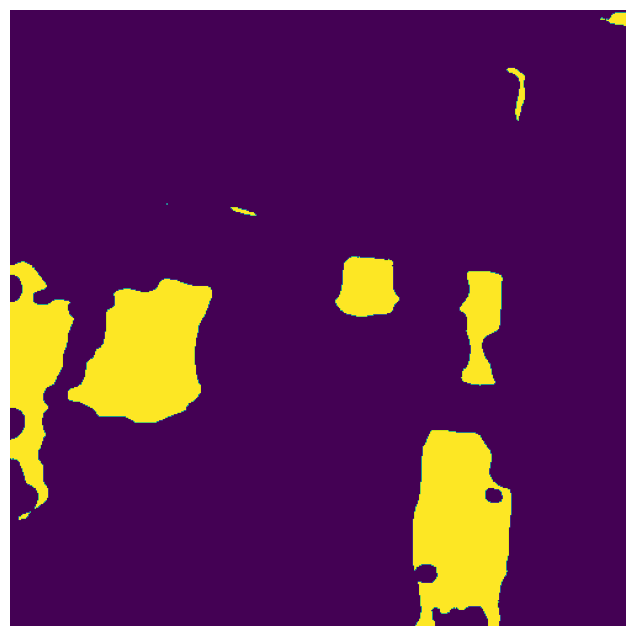

In [17]:
utils.show_image(binary_mask.reshape(500, 500, 1))

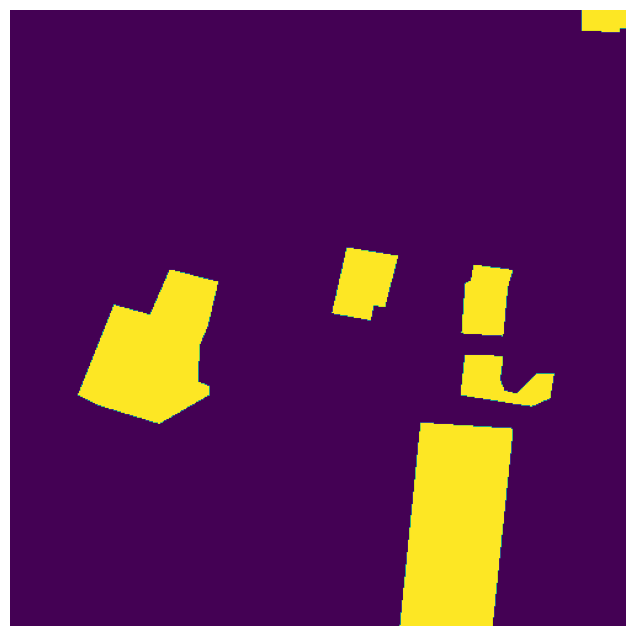

In [18]:
utils.show_image(gt_mask.cpu().numpy().reshape(500, 500, 1))

In [19]:
from segment_anything.utils.transforms import ResizeLongestSide
dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

idx = 12

item = dataset["test"][idx]
image = item["image"]
np_image = np.array(item["image"])
size = np_image.shape[0]

# prepare the image for the model
transform = ResizeLongestSide(1024)
input_image = transform.apply_image(np_image)
input_image = torch.as_tensor(input_image, device=sm.device)
input_image = input_image.permute(2, 0, 1).contiguous()[None, :, :, :]

# preprocess the image
input_image = sm.sam.preprocess(input_image).squeeze()

with torch.no_grad():
    features = sm.sam.image_encoder(input_image.reshape(1, 3, 1024, 1024))
    output_mask = decoder(features)

# get the ground truth segmentation mask
gt_mask = utils.get_segmentation_mask(item["objects"]['segmentation'], size)
gt_mask = gt_mask.reshape((1, 1, size, size)).astype('float32')

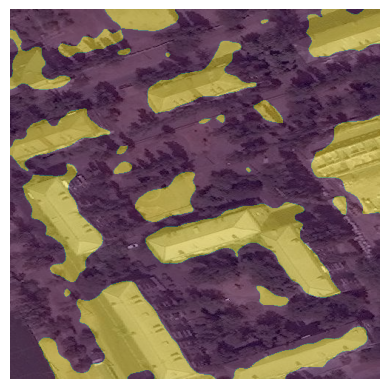

In [20]:
from torch.nn import functional as F

# Apply a threshold to get the binary mask
thresholded_mask = F.threshold(output_mask, 0.4, 0)
binary_mask = F.normalize(thresholded_mask)

# Convert the binary mask tensor to a numpy array and remove the batch dimension
binary_mask = binary_mask.squeeze(0).cpu().numpy()
binary_mask = np.expand_dims(binary_mask, axis=0)
utils.show_masks(np_image, binary_mask)

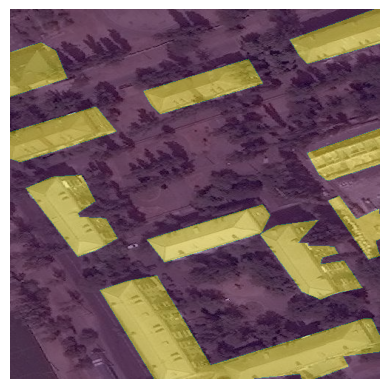

In [21]:
utils.show_masks(np_image, gt_mask)